In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import cv2
from sklearn.model_selection import train_test_split

np.random.seed(0)

# Load data into dataframe
training_data_folder = 'asl_alphabet_train'
data = []

for folder in sorted(os.listdir(training_data_folder)):
    sub_folder = os.path.join(training_data_folder,folder)
    files = [{'label':folder,'path':os.path.join(sub_folder, f)} for f in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder, f))]
    data += files

df = pd.DataFrame(data)

train_dir="asl_alphabet_train"
labels_dict,map_characters = {},{}
order_list=[]
for i in range(26):
    c=chr(ord('A')+i)
    labels_dict[c]=i
    map_characters[i]=c
    order_list+=c
    
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()

hotEncodedLabels=lb.fit_transform(order_list)
    
# df.to_csv("labelPath.csv",index=False)
# df2 = pd.read_csv('labelPath.csv')
# df2.head()



In [25]:
def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder): #/mnt/d/Zaken/Desktop/computer science/DeepLearningClassificationASL/asl_alphabet_train/A/A1.jpg
            save=train_dir + '/' + folder + '/' + image
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image, 0) # greyscale
            temp_img = cv2.resize(temp_img, size)
            temp_img = temp_img.flatten()
            images.append(temp_img)
            labels.append(hotEncodedLabels[labels_dict[folder]])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.3, random_state=42,shuffle=True)
    X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size = 0.8,random_state=42,shuffle=True)
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_validation),'images for validation','validation data shape =',X_validation.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)

    return X_train, X_test, Y_train, Y_test, X_validation, Y_validation

X_train, X_test, Y_train, Y_test, X_validation, Y_validation= load_data()




LOADING DATA FROM : A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | 
Loaded 54600 images for training, Train data shape = (54600, 4096)
Loaded 18720 images for validation validation data shape = (18720, 4096)
Loaded 4680 images for testing Test data shape = (4680, 4096)


In [26]:

categories = 26
features= 4096
x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, categories])
W = tf.Variable(tf.zeros([features,categories]))
b = tf.Variable(tf.zeros([categories]))

z = tf.matmul(x, W) +b 
pred = tf.nn.softmax(z) 
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(y_, z))
update = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

data_x=np.array(X_train)
data_y=np.array(Y_train)
data_arr_x=[data_x[0::5],data_x[1::5],data_x[2::5],data_x[3::5],data_x[4::5]]
data_arr_y=[data_y[0::5],data_y[1::5],data_y[2::5],data_y[3::5],data_y[4::5]]
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(75000): # took 10 hours to run
   
    sess.run(update, feed_dict = {x:data_arr_x[i%5], y_:data_arr_y[i%5]}) 
    if(i%5000==0):
        print(i,':')
        correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(sess.run(accuracy, feed_dict={x: X_validation, y_: Y_validation}))
    


2022-12-07 21:44:47.783448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 178913280 exceeds 10% of free system memory.


0 :


2022-12-07 21:44:49.583377: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 306708480 exceeds 10% of free system memory.


0.054113247


2022-12-07 21:44:54.428191: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 178913280 exceeds 10% of free system memory.
2022-12-07 21:44:55.151199: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 178913280 exceeds 10% of free system memory.
2022-12-07 21:44:55.706669: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 178913280 exceeds 10% of free system memory.


5000 :
0.38963675
10000 :
0.45005342
15000 :
0.49043804
20000 :
0.517094
25000 :
0.53771365
30000 :
0.55448717
35000 :
0.56832266
40000 :
0.579968
45000 :
0.5903846
50000 :
0.60010684
55000 :
0.6081731
60000 :
0.61549145
65000 :
0.62248933
70000 :
0.6282051


In [27]:
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: X_test, y_: Y_test}))
    

0.63141024


0.63141024


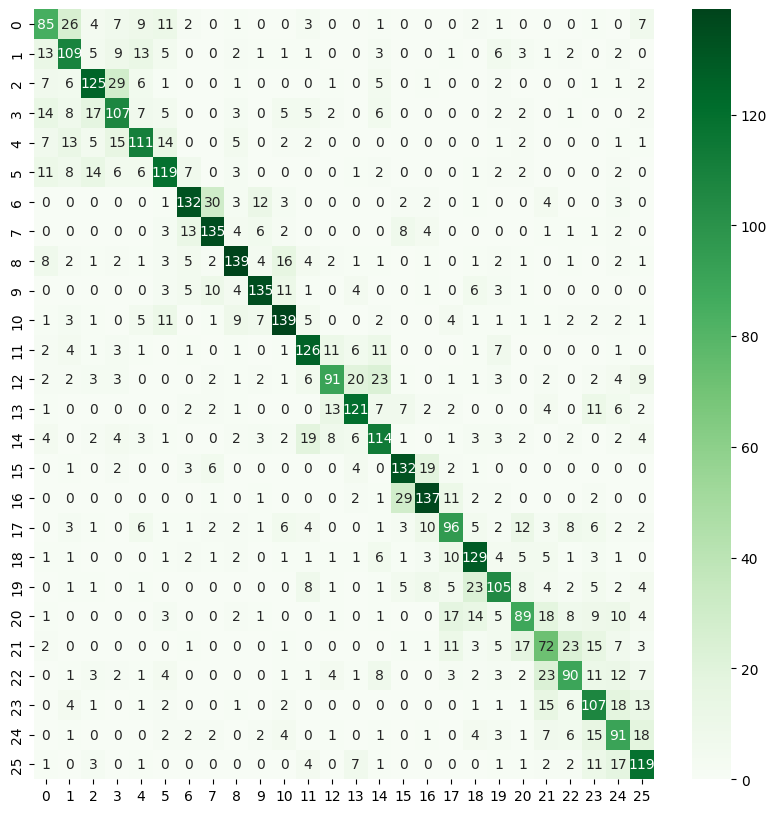

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# function to make pretty confusion matrix
def confussion_matrix(cf_matrix):
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')

# make a tensor with the y validation 
y_vald=[]
for i in Y_test:
    y_vald.append(i.tolist())
y_vald_t=tf.convert_to_tensor(
    y_vald, dtype=None, dtype_hint=None, name=None
)


# get the prediction foe x validation

mypred=sess.run(pred,feed_dict={x: X_test, y_: Y_test})


# check accuracy
correct_prediction1 = tf.equal(tf.argmax(mypred,1), tf.argmax(y_vald_t,1))
accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))
print(sess.run(accuracy1))


# take mypred change to a list then to a tensor
mypred_l=[]
for i in mypred:
    mypred_l.append(i.tolist())

mypred_t=tf.convert_to_tensor(
    mypred_l, dtype=None, dtype_hint=None, name=None
)


# create a list with the pred class
pred_confussion_matrix=[]
for i in sess.run(mypred_t):
    pred_confussion_matrix.append( np.argmax(i))

# create a list with the actual class
Y_validation_confussion_matrix=[]
for i in sess.run(y_vald_t):
    Y_validation_confussion_matrix.append( np.argmax(i))

# create the cunfusion matrix
confussion_matrix(confusion_matrix(Y_validation_confussion_matrix,pred_confussion_matrix))

   